Author: Hao-Li Huang

This project is modified from the final assignment from the Applied Machine Learning in Python course. We want to build a model to predict if property maintenance fines would be paid on time. 
<br><br>
To validate the models without data leakage, I built a customized transformer class to be used in a pipeline.
A model with an Area Under ROC Curve score of **0.75** will get full credit. I was able to optimize a Random Forest Classifier to an Area Under ROC Curve score of **0.845**.
<br><br>
The original instruction is as follows. Note that some of the hyperlinks in it might be invalid now.

---

## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
      
---

# 1. Loading and Cleaning Data

In [1]:
import pandas as pd
import numpy as np
    
train = pd.read_csv('train.csv', engine='python')
test = pd.read_csv('test.csv', engine='python')
addresses = pd.read_csv('addresses.csv', engine='python') # ticket_id, address
latlons = pd.read_csv('latlons.csv', engine='python') # address, lat, lon

A list of `ticket_id` and corresponding `address` is provided to us in `addresses.csv`, and so is a list of `address` with corresonding latitude (`lat`) and longitude (`lon`) in `latlons.csv`. I first merge them both to the `train` and `test` data frames.

In [2]:
ad_latlons = pd.merge(addresses, latlons, how='left', on='address')
train = pd.merge(train, ad_latlons, how='left', on='ticket_id')
test = pd.merge(test, ad_latlons, how='left', on='ticket_id')

According to the instruction, we don't consider the case when `compliance` is `NaN`. I also decided to not use the columns that are not included in the `test` data frame.

In [3]:
# Only consider violators responsible for the ticket (compliance is not NaN)
train = train[~ np.isnan(train['compliance'])]
# Drop the columns in train but not in test
train = train.drop(['payment_amount', 'payment_date', 'payment_status', 'balance_due', 
                    'collection_status', 'compliance_detail'], axis=1)

Next, I manually inspected the missing values in `lat` and `lon`, and filled in the missing values.

In [4]:
# Check missing lat, lon values
train[train['lat'].isna()][['address', 'lat', 'lon']]

,address,lat,lon
65578,"20424 bramford, Detroit MI",NaN,NaN
191722,"445 fordyce, Detroit MI",NaN,NaN


In [5]:
test[test['lat'].isna()][['address', 'lat', 'lon']]

,address,lat,lon
20459,"20424 bramford, Detroit MI",NaN,NaN
28350,"8325 joy rd, Detroit MI 482O4",NaN,NaN
28416,"1201 elijah mccoy dr, Detroit MI 48208",NaN,NaN
31925,"12038 prairie, Detroit MI 482O4",NaN,NaN
55400,"6200 16th st, Detroit MI 482O8",NaN,NaN


In [6]:
### Look up the lat and lon of the adresses with missing lat and lon
### and manuallly fill them in

train.loc[65578,['lat', 'lon']] = 42.446540, -83.023300
train.loc[191722,['lat', 'lon']] = 42.353240, -83.066120

test.loc[20459,['lat', 'lon']] = 42.446540, -83.023300
test.loc[28350,['lat', 'lon']] = 42.358910, -83.151329
test.loc[28416,['lat', 'lon']] = 42.359720, -83.080190
test.loc[31925,['lat', 'lon']] = 42.376720, -83.143211
test.loc[55400,['lat', 'lon']] = 42.359919, -83.095843

Now, we come back to check the missing values in the original `train` and `test` datasets. I used `isna()` and `mean()` methods to see the fraction of the data that are missing.

In [7]:
# Check missing values
train.isna().mean()

ticket_id                     0.000000
agency_name                   0.000000
inspector_name                0.000000
violator_name                 0.000163
violation_street_number       0.000000
violation_street_name         0.000000
violation_zip_code            1.000000
mailing_address_str_number    0.015999
mailing_address_str_name      0.000019
city                          0.000000
state                         0.000525
zip_code                      0.000006
non_us_str_code               0.999981
country                       0.000000
ticket_issued_date            0.000000
hearing_date                  0.001420
violation_code                0.000000
violation_description         0.000000
disposition                   0.000000
fine_amount                   0.000000
admin_fee                     0.000000
state_fee                     0.000000
late_fee                      0.000000
discount_amount               0.000000
clean_up_cost                 0.000000
judgment_amount          

Three columns are mostly missing: `violation_zip_code`, `non_us_str_code`, and `grafitti_status`. These columns will be dropped. In addition, I also decided to drop all address-related columns, as the information is already captured by `lat` and `lon`. Lastly, I dropped `ticket_id` because it does not help with training our model.

In [8]:
cols_to_drop = ['ticket_id', 'violation_street_number', 'violation_street_name', 
                'violation_zip_code', 'mailing_address_str_number', 
                'mailing_address_str_name', 'city', 'state', 'zip_code', 
                'non_us_str_code', 'country', 'grafitti_status', 'address']

train = train.drop(cols_to_drop, axis=1)

test_id = test['ticket_id'] # Take a note of test_id for submission
test = test.drop(cols_to_drop, axis=1)

Then, we look at the distribution of the values in the remaining numeric features using the `describe()` method.

In [9]:
train.describe()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon
count,159880.000000,159880.0,159880.0,159880.000000,159880.000000,159880.0,159880.000000,159880.000000,159880.000000,159880.000000
mean,357.035295,20.0,10.0,33.651512,0.195959,0.0,420.650218,0.072536,42.389747,-83.111529
std,675.655580,0.0,0.0,67.692916,4.290344,0.0,742.555062,0.259374,0.037120,0.093515
min,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,42.145257,-84.403766
25%,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,42.364535,-83.185854
50%,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.392575,-83.124517
75%,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.419160,-83.033202
max,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,1.000000,44.785389,-82.512936


First, we notice that the dependent variable that we try to predict, `compliance`, is unbalanced. Most of `compliance` has a value of `0`, meaning, not paid on time. Therefore, to validate the model later, we will use ROC AUC score (area under the receiver operating characteristic curve), instead of accuracy score.

We see that `admin_fee`, `state_fee`, and `clean_up_cost` have the same value across all rows, so we will drop these columns. 
<br>
In addition, if a blight ticket is charged a `late_fee`, the amount would always be 10% of `fine_amount`. This creates a collinearity, which is not desirable when training certain models. The useful information might be 'if there is a late fee', so I decided to add a categorical column `is_late` (Y/N), and then dropped `late_fee`.

In [10]:
cols_to_drop = ['admin_fee', 'state_fee', 'clean_up_cost']
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# Transform late_fee to a categorical feature: is_late (Y/N)
for df in [train, test]:
    df['is_late'] = df['late_fee'].apply(lambda c: 'N' if c == 0 else 'Y')
    df = df.drop('late_fee', axis=1, inplace=True)

Next, we look at the categorical features using `describe(include = ['O'])`.

In [11]:
train.describe(include = ['O'])

,agency_name,inspector_name,violator_name,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,is_late
count,159880,159880,159854,159880,159653,159880,159880,159880,159880
unique,5,159,84656,68097,5970,189,207,4,2
top,"Buildings, Safety Engineering & Env Department","Morris, John","INVESTMENT, ACORN",2007-12-21 09:00:00,2005-12-20 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,Y
freq,95863,11604,624,60,590,64414,64414,138340,144422


First, `ticket_issued_date` and `hearing_date` are not categorical features. They should be treansformed into numeric features.
<br><br>
Next, It appears that `violation_description` and `violation_code` contains the identical information, so we will drop the former.
<br><br>
Lastly, I plan to use the one hot encoder to encode the categorical features, only keeping the categories with frequencies > 5% (chosen arbitrarily and can be optimized), and substituting infrequent categories with 'rare'. Because the most freqent category in `violator_name` is around 0.4%, all values in this features will become 'rare', so this feature is not going to be useful. We will drop this feature as well.

In [12]:
# No violator name has more than 5% share
train.describe(include = ['O']).loc['freq']/len(train)

agency_name                 0.599593
inspector_name             0.0725794
violator_name             0.00390293
ticket_issued_date       0.000375281
hearing_date              0.00369027
violation_code               0.40289
violation_description        0.40289
disposition                 0.865274
is_late                     0.903315
Name: freq, dtype: object

In [13]:
# violation code and ciolation description are the same information
# Also drop violation name because even the most frequent one occurs < 0.4%
cols_to_drop = ['violation_description', 'violator_name']
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# Change the date columns into datetime object
dt_cols = ['ticket_issued_date', 'hearing_date']
for col in dt_cols:
    train[col] = pd.to_datetime(train[col])
    test[col] = pd.to_datetime(test[col])

Now we have looked into every feature in the dataset. Let's check again if there are any missing values remained.

In [14]:
train.isna().sum() 

agency_name             0
inspector_name          0
ticket_issued_date      0
hearing_date          227
violation_code          0
disposition             0
fine_amount             0
discount_amount         0
judgment_amount         0
compliance              0
lat                     0
lon                     0
is_late                 0
dtype: int64

There are only a few missing values in `hearing_date`, which I will tackle by building a custumized transformer class in the following section.

# 2. Customized Transformer Class

To avoid data leakage in the cross validation process, I built a customized transformer to carry out a series of transformations to the data prior model training. 
<br><br>
The transformations are <br>
(a) impute missing values in `hearing_date`, <br>
(b) replace infrequent categories in categorical features with 'rare', <br>
(c) transform datetime features into a series of numeric features, <br>
(d) cluster the locations using `lat` and `lon`, and <br>
(e) engineer additional features using `lat` and `lon` to capture more of the spatial information.

In [15]:
# Customized transformer: Inherenting BaseEstimator and TransformerMixin class
# The former gives us get_params and set_params methods, 
# and the latter gives us fit_transform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class CustomizedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_features = ['agency_name', 'inspector_name', 
                            'violation_code', 'disposition']
        
    def fit(self, X, y=None):
        # Compute the median wait time between hearing date and ticket issued date
        self.median_wait_time = (X['hearing_date'] - X['ticket_issued_date']).median()
        
        self.common_categories = []
        for col in self.cat_features:
            # Select categories appearing more than 5% of the time
            com_cat = X[col].value_counts()/len(X) > 0.05
            com_cat = list(com_cat[com_cat == True].index)
            self.common_categories.append(com_cat)
            
        # Cluster locations based on lat and lon
        self.kmeans = KMeans(n_clusters=20).fit(X[['lat', 'lon']])
        # Record mean of lat and lon
        self.lat_mean = X['lat'].mean()
        self.lon_mean = X['lon'].mean()
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        # Impute missing hearing date using median wait time
        X['hearing_date'] = X['hearing_date'].fillna(
            X['ticket_issued_date'] + self.median_wait_time)
        
        # Add datetime-related features
        X['wait_time'] = (X['hearing_date'] - X['ticket_issued_date']).dt.days
        
        X['ticket_date_month'] = X['ticket_issued_date'].dt.month
        X['ticket_date_week'] = X['ticket_issued_date'].dt.isocalendar().week
        X['ticket_date_day'] = X['ticket_issued_date'].dt.day
        X['ticket_date_hour'] = X['ticket_issued_date'].dt.hour
        X['ticket_date_dayofweek'] = X['ticket_issued_date'].dt.dayofweek
        
        X['hearing_date_month'] = X['hearing_date'].dt.month
        X['hearing_date_week'] = X['hearing_date'].dt.isocalendar().week
        X['hearing_date_day'] = X['hearing_date'].dt.day
        X['hearing_date_hour'] = X['hearing_date'].dt.hour
        X['hearing_date_dayofweek'] = X['hearing_date'].dt.dayofweek
        
        # Drop datetime features that are not compatible with the model
        X = X.drop(['hearing_date', 'ticket_issued_date'], axis=1)
        
        for i, col in enumerate(self.cat_features):
            com_cat = self.common_categories[i]
            # Replace uncommon categories and NaN with 'rare' 
            X[col] = X[col].apply(lambda c: c if c in com_cat else 'rare')
            X[col] = X[col].fillna('rare')
            
        # Cluster locations
        X['cluster'] = self.kmeans.predict(X[['lat', 'lon']])
        # Add product of lat and lon to capture more spatial information
        X['xy'] = (X['lat'] - self.lat_mean) * (X['lon'] - self.lon_mean)
        X['r'] = np.sqrt((X['lat'] - self.lat_mean)**2 + (X['lon'] - self.lon_mean)**2)
        X['theta'] = np.arctan(X['lon'] / X['lat'])
        
        return X

# 3. Model Selection

In this section, I tried out several classifiers (Naive Bayes, Logistic Regression, Random Forset, Bradient Boosting, and XGBoost) with their default parameters using stratified 5-fold cross validation, and then chose the best ones for further hyperparameter optimization. 
<br><br>
Again, we build a pipeline to avoid data leakage during the cross validation. The first step in the pipeline is to transform the data using the customized transformer built in the previous section. Then, I transform the categorical features using `OneHotEncoder`, and scale the numeric features using `MinMaxScaler`. These are wrapped in `preprocessor` using `ColumnTransformer`. At this point, the data are transformed into a sparse matrix, not accepted by some classifiers, so we transform it back to a dense matrix using `FunctionTransformer`. Lastly, we pass in the classifiers with default setting.

In [16]:
# Pipeline, transformer, scaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
# For cross validation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
# To calculate roc_auc scores
from sklearn.metrics import roc_auc_score, roc_curve
# To dra confusion matrix
from sklearn.metrics import plot_confusion_matrix 

# Classifiers to test
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For simple plots
import matplotlib.pyplot as plt

In [17]:
### Train-test split
y = train['compliance'].copy()
X = train.drop('compliance', axis=1).copy()
# Becase the data is inbalanced, we use stratified train_test_split to 
# ensure similar proportions of compliance in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

### Pipeline:
# 1. Transform data using CustomizedTransformer
# 2. One hot encoder for categorical features
# 3. Try out a couple classifiers

# List of numeric and categorical features
numeric_features = ['fine_amount', 'discount_amount', 'judgment_amount', 
                    'lat', 'lon', 'wait_time', 'xy', 'r', 'theta']
categorical_features = list(set(CustomizedTransformer().fit_transform(X).columns) \
                        - set(numeric_features))

# One hot encoder
ohe = OneHotEncoder(handle_unknown = 'ignore')

# Preprocessor: OneHotEncoder for categorical features, 
# MinMaxScaler for numeric features
preprocessor = ColumnTransformer(
                        transformers = [('cat', ohe, categorical_features), 
                                        ('num', MinMaxScaler(), numeric_features)
                                        ])

# Classifiers to test
classifiers = [GaussianNB(),
               LogisticRegression(),  
               RandomForestClassifier(), 
               GradientBoostingClassifier(),
               XGBClassifier()]

In [18]:
for clf in classifiers:
    pipe = Pipeline(steps = [('transformer', CustomizedTransformer()),
                             ('ohe_scaler', preprocessor),
                             # Convert sparse matrix to dense matrix: some classifiers 
                             # throw error messages when seeing a sparse matrix. 
                             ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                     accept_sparse = True)),
                             ('clf', clf)
                            ])
    
    scores = cross_validate(pipe, X_train, y_train, scoring='roc_auc', 
                            cv=StratifiedKFold(), n_jobs=-1, return_train_score=True)

    print('AUC_train for {} = {:.3f}'.format(str(clf).split('(')[0], 
                                             scores['train_score'].mean()))
    print('AUC_cross_val for {} = {:.3f}'.format(str(clf).split('(')[0], 
                                            scores['test_score'].mean()))

AUC_train for GaussianNB = 0.757
AUC_cross_val for GaussianNB = 0.748
AUC_train for LogisticRegression = 0.805
AUC_cross_val for LogisticRegression = 0.793
AUC_train for RandomForestClassifier = 1.000
AUC_cross_val for RandomForestClassifier = 0.827
AUC_train for GradientBoostingClassifier = 0.828
AUC_cross_val for GradientBoostingClassifier = 0.819
AUC_train for XGBClassifier = 0.927
AUC_cross_val for XGBClassifier = 0.831


I tested 5 algorithms using default parameters. Naive Bayes mostly serves as a baseline, and it not surprisingly performs worst here. The best cross validation scores come from Random Forest and XGBoost, so I will focus on these two and tune the hyperparameters for even better fits. We see that for both algorithms, the train scores are significantly higher than the cross validation scores, indicating overfits.

# 4. Hyperparameter Optimization

## 4.1. Random Forest

In [19]:
from sklearn.model_selection import GridSearchCV

Let's first look at the default parameters. This would be the starting point of the tuning. Because the model appears to be overfitting, we will try to reduce the complexity of the model to make the model generalize better.

In [20]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's run the default Random Forest model again, and plot the confusion matrix. We will compare the roc_auc scores and the confusion matrix before and after the optimization.

In [21]:
clf_rf = RandomForestClassifier(n_jobs=-1)
pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
pipe_rf.fit(X_train, y_train)
y_test_pred_before = pipe_rf.predict_proba(X_test)[:,1] # For comparing ROC curves

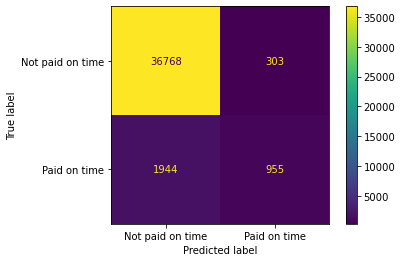

In [22]:
plot_confusion_matrix(pipe_rf, X_test, y_test, display_labels = 
                      ['Not paid on time', 'Paid on time']);

(The numbers might change slightly due to the randomization.)
<br>
Using the default parameters, of the **36768 + 303 = 37071** people who didn't pay the ticket on time, **36768 (99.18%)** are correctly classified. Of the **1944 + 955 = 2899** people who paid on time, only **955 (32.94%)** are correctly classified.
<br><br>
Next, I vary a couple important hyperparameters one by one, and plot out their effects to the roc_auc scores. I will choose the best parameter to plug in the model, and then scan the next parameter. 
<br><br>
Note that since I have rerun the whole notebook, the chosen best parameter might not be the same as the one that appears to be the best this time, although the chosen one would still be almost as good. A fixed random seed would eliminate the randomness. 

In [23]:
# Number of trees in the forest
n_estimators = [100, 300, 500, 750, 1000, 1500, 2000]

train_scores = [] 
test_scores = []

# Create one random forest per value for n_estimators 
for n_estimator in n_estimators:
    clf_rf = RandomForestClassifier(n_estimators=n_estimator, 
                                    max_samples=0.7, n_jobs=-1)
    
    pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
    pipe_rf.fit(X_train, y_train)
    
    y_train_pred = pipe_rf.predict_proba(X_train)[:,1]
    y_test_pred = pipe_rf.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

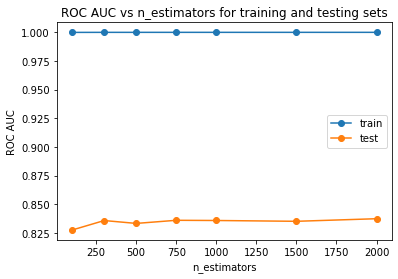

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel('n_estimators')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs n_estimators for training and testing sets')
ax.plot(n_estimators, train_scores, marker='o', label='train')
ax.plot(n_estimators, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [25]:
# Cost complexity pruning
ccp_alphas = [0, 4e-6, 8e-6, 1e-5, 1.2e-5, 1.4e-5, 1.6e-5, 2e-5, 2.4e-5]

train_scores = [] 
test_scores = []

# Create one random forest per value for ccp_alpha
for ccp_alpha in ccp_alphas:
    clf_rf = RandomForestClassifier(ccp_alpha = ccp_alpha, 
                                    n_estimators = 1000,
                                    max_samples=0.7, n_jobs=-1)
    
    pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
    pipe_rf.fit(X_train, y_train)
    
    y_train_pred = pipe_rf.predict_proba(X_train)[:,1]
    y_test_pred = pipe_rf.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

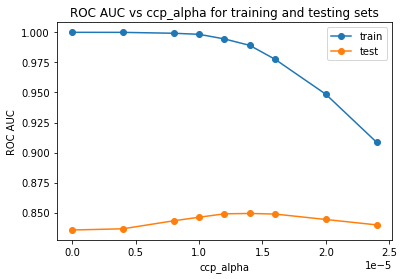

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('ccp_alpha')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs ccp_alpha for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train')
ax.plot(ccp_alphas, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [27]:
# Max number of features considered for splitting a node
max_features = [7, 8, 9, 10, 11, 12, 13, 14, 15, 20]

train_scores = [] 
test_scores = []

# Create one random forest per value for max_features
for max_feature in max_features:
    clf_rf = RandomForestClassifier(max_features=max_feature,
                                    ccp_alpha = 1.2e-5, n_estimators = 1000,
                                    max_samples=0.7, n_jobs=-1)
    
    pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
    pipe_rf.fit(X_train, y_train)
    
    y_train_pred = pipe_rf.predict_proba(X_train)[:,1]
    y_test_pred = pipe_rf.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

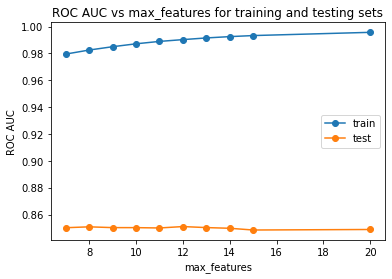

In [28]:
fig, ax = plt.subplots()
ax.set_xlabel('max_features')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs max_features for training and testing sets')
ax.plot(max_features, train_scores, marker='o', label='train')
ax.plot(max_features, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [29]:
# Min number of samples required to split a node
min_samples_splits = [2, 3, 4, 5, 6, 10, 15]

train_scores = [] 
test_scores = []

# Create one random forest per value for min_samples_split
for min_samples_split in min_samples_splits:
    clf_rf = RandomForestClassifier(min_samples_split = min_samples_split, 
                                    max_features = 9,
                                    ccp_alpha = 1.2e-5, n_estimators = 1000, 
                                    max_samples=0.7, n_jobs=-1)
    
    pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
    pipe_rf.fit(X_train, y_train)
    
    y_train_pred = pipe_rf.predict_proba(X_train)[:,1]
    y_test_pred = pipe_rf.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

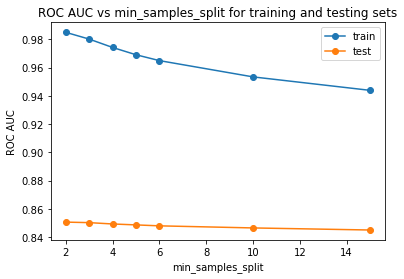

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs min_samples_split for training and testing sets')
ax.plot(min_samples_splits, train_scores, marker='o', label='train')
ax.plot(min_samples_splits, test_scores, marker='o', label='test')

ax.legend()
plt.show()

Now that we get a good understanding of the rough ranges of each parameter, we can do a grid search CV to search the best combination. However, because this is a pretty big data set and the `GridSearchCV` takes a significant amount of time to run, I'm going to skip this step and just use the best parameters I get so far. 

In [31]:
# clf_rf = RandomForestClassifier(n_jobs = -1)

# pipe = Pipeline(steps = [('transformer', CustomizedTransformer()),
#                         ('ohe_scaler', preprocessor),
#                         ('todense', FunctionTransformer(lambda x: x.todense(), 
#                                                 accept_sparse = True)),
#                         ('clf', clf_rf)
#                         ])

# param_grid = {'clf__n_estimators': [750, 1000, 1500],
#               'clf__ccp_alpha': [1e-5, 1.2e-5, 1.4e-5],
#               'clf__max_features': [8, 9, 10],
#               'clf__min_samples_split': [2, 3, 4]}

# search = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv = StratifiedKFold(), 
#                       verbose = 2)
# search.fit(X_train, y_train)
# print('Random forest best parameter (CV score = {:3f}):'.format(search.best_score_))
# print(search.best_params_)

In [32]:
clf_rf = RandomForestClassifier(min_samples_split = 2, max_features = 9,
                                ccp_alpha = 1.2e-5, n_estimators = 750, n_jobs = -1)
pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
    
scores = cross_validate(pipe_rf, X_train, y_train, scoring='roc_auc', 
                        cv=StratifiedKFold(), return_train_score=True)

print('AUC_train for optimized Random Forest = {:.3f}'.format(
                                                        scores['train_score'].mean()))
print('AUC_cross_val for optimized Random Forest = {:.3f}'.format(
                                                        scores['test_score'].mean()))

AUC_train for optimized Random Forest = 0.994
AUC_cross_val for optimized Random Forest = 0.845


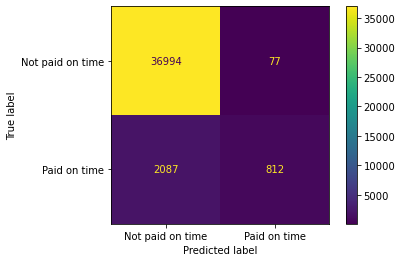

In [33]:
pipe_rf.fit(X_train, y_train)
plot_confusion_matrix(pipe_rf, X_test, y_test, display_labels = 
                      ['Not paid on time', 'Paid on time']);

After the optimization, the cross validation roc_auc score increased significantly from **0.827** to **0.845**!
<br><br>
Looking at the new confusion matrix, of the **37071** people who didn't pay the ticket on time, **36994 (99.79%)** are correctly classified (true negative rate). Of the **2899** people who paid on time, **812 (28.00%)** are correctly classified (true positive rate).
<br><br> 
The false positive rate is **FP / (FP + TN) = 77 / (77 + 36994) = 0.23%**, so the threshold we use now corresponds to the point **(FPR, TPR) = (0.0023, 0.2800)** in the following ROC curve plot. Right now, the model does really well on classifying the 'Not paid on time' cases, which should be important for the purpose of this model, since we want to understand why people don't pay the fine on time. However, we can always increase the true positive rate to better classify the cases of 'Paid on time' at the cost of a increasing false positive rate, illustrated in the following ROC curve, by changing the threshold.
<br><br>
Lastly, we visualize the improvement of hyperparameter tuning by plotting out the ROC curves before and after the optimization. The new curve is more to the upper-left (larger area under curve), and thus represents a better model.

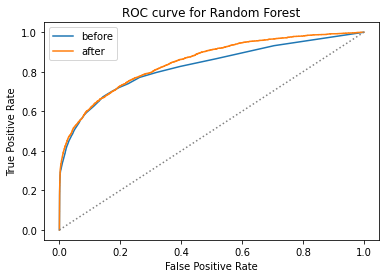

In [34]:
y_test_pred = pipe_rf.predict_proba(X_test)[:,1]
fpr_rf_before, tpr_rf_before, _ = roc_curve(y_test, y_test_pred_before)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)

fig, ax = plt.subplots()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for Random Forest')
ax.plot(fpr_rf_before, tpr_rf_before, label='before')
ax.plot(fpr_rf, tpr_rf, label='after')
ax.legend()
ax.plot([0, 1], [0, 1], ':', c='grey');

## 4.2. XGBoost

Then, we do the same with the XGBoost Classifier.

In [35]:
clf_xgb = XGBClassifier(objective='binary:logistic',
                            eval_metric='auc', use_label_encoder=False)

pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])

pipe_xgb.fit(X_train, y_train)
y_test_pred_before = pipe_xgb.predict_proba(X_test)[:,1] # For comparing ROC curves

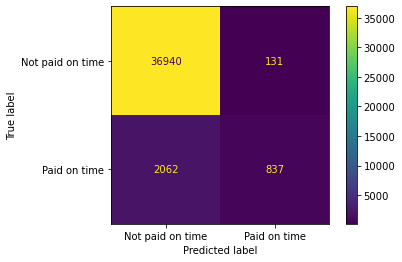

In [36]:
plot_confusion_matrix(pipe_xgb, X_test, y_test, display_labels = 
                      ['Not paid on time', 'Paid on time']);

(The numbers might change slightly due to the randomization.)
<br>
Using the default parameters, of the **36940 + 131 = 37071** people who didn't pay the ticket on time, **36940 (99.65%)** are correctly classified. Of the **2062 + 837 = 2899** people who paid on time, only **837 (28.87%)** are correctly classified.
<br><br>
I also tried to vary parameters one by one. However, I found that the hyperparameters had little effects on the roc_auc scores.

In [37]:
# Number of trees in the forest
n_estimators = [100, 300, 500, 750, 1000, 1500]

train_scores = [] 
test_scores = []

## now create one xgboost per value for n_estimators 
for n_estimator in n_estimators:
    clf_xgb = XGBClassifier(n_estimators = n_estimator,
                        objective='binary:logistic', eval_metric='auc', 
                        use_label_encoder=False, n_jobs=-1)
    
    pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
    pipe_xgb.fit(X_train, y_train)
    
    y_train_pred = pipe_xgb.predict_proba(X_train)[:,1]
    y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

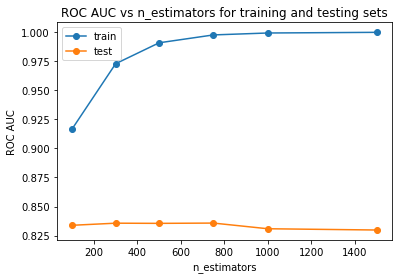

In [38]:
fig, ax = plt.subplots()
ax.set_xlabel('n_estimators')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs n_estimators for training and testing sets')
ax.plot(n_estimators, train_scores, marker='o', label='train')
ax.plot(n_estimators, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [39]:
# Max depths of a tree
max_depths = [5, 8, 9, 10, 11, 12, 15, 25]

train_scores = [] 
test_scores = []

## now create one xgboost per value for max_depth 
for max_depth in max_depths:
    clf_xgb = XGBClassifier(max_depth = max_depth,
                            n_estimators = 500,
                            objective='binary:logistic', eval_metric='auc', 
                            use_label_encoder=False, n_jobs=-1)
    
    pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
    pipe_xgb.fit(X_train, y_train)
    
    y_train_pred = pipe_xgb.predict_proba(X_train)[:,1]
    y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

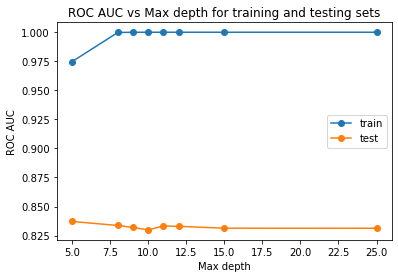

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel('Max depth')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs Max depth for training and testing sets')
ax.plot(max_depths, train_scores, marker='o', label='train')
ax.plot(max_depths, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [41]:
# Min loss reduction required to further split a node
gammas = [0, 0.2, 0.4, 0.6, 1]

train_scores = [] 
test_scores = []

## now create one xgboost per value for gamma 
for gamma in gammas:
    clf_xgb = XGBClassifier(gamma = gamma, 
                            max_depth = 11, n_estimators = 500, 
                            objective='binary:logistic', eval_metric='auc', 
                            use_label_encoder=False, n_jobs=-1)
    
    pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
    pipe_xgb.fit(X_train, y_train)
    
    y_train_pred = pipe_xgb.predict_proba(X_train)[:,1]
    y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

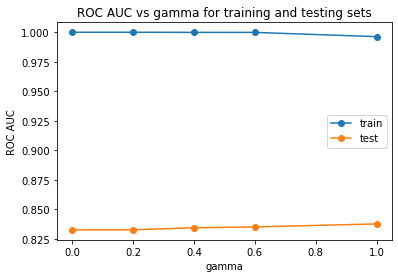

In [42]:
fig, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs gamma for training and testing sets')
ax.plot(gammas, train_scores, marker='o', label='train')
ax.plot(gammas, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [43]:
# L2 regularization term on weights
reg_lambdas = [0, 3, 4, 5, 6, 7, 10]

train_scores = [] 
test_scores = []


for reg_lambda in reg_lambdas:
    clf_xgb = XGBClassifier(reg_lambda = reg_lambda, 
                            max_depth = 11, n_estimators = 500, 
                            objective='binary:logistic', eval_metric='auc', 
                            use_label_encoder=False, n_jobs=-1)
    
    pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
    pipe_xgb.fit(X_train, y_train)
    
    y_train_pred = pipe_xgb.predict_proba(X_train)[:,1]
    y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

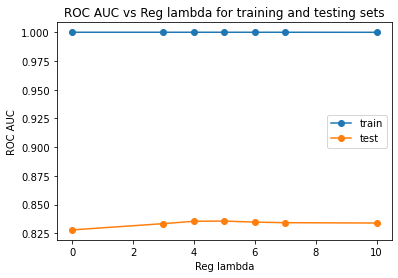

In [44]:
fig, ax = plt.subplots()
ax.set_xlabel('Reg lambda')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs Reg lambda for training and testing sets')
ax.plot(reg_lambdas, train_scores, marker='o', label='train')
ax.plot(reg_lambdas, test_scores, marker='o', label='test')
ax.legend()
plt.show()

In [45]:
# Step size used in updates
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

train_scores = [] 
test_scores = []


for learning_rate in learning_rates:
    clf_xgb = XGBClassifier(learning_rate = learning_rate,
                            max_depth = 11, reg_lambda = 5, n_estimators = 500,
                            objective='binary:logistic', eval_metric='auc', 
                            use_label_encoder=False, n_jobs=-1)
    
    pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
    pipe_xgb.fit(X_train, y_train)
    
    y_train_pred = pipe_xgb.predict_proba(X_train)[:,1]
    y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]

    train_score = roc_auc_score(y_train, y_train_pred)
    test_score = roc_auc_score(y_test, y_test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

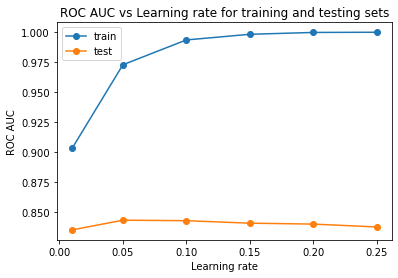

In [46]:
fig, ax = plt.subplots()
ax.set_xlabel('Learning rate')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC vs Learning rate for training and testing sets')
ax.plot(learning_rates, train_scores, marker='o', label='train')
ax.plot(learning_rates, test_scores, marker='o', label='test')
ax.legend()
plt.show()

Again, the grid search CV is skipped.

In [47]:
# clf_xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', 
#                         use_label_encoder=False, n_jobs=-1)

# pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
#                         ('ohe_scaler', preprocessor),
#                         ('clf', clf_xgb)
#                         ])

# param_grid = {'clf__n_estimators': [500, 1000],
#               'clf__max_depth': [10, 11, 12],
#               'clf__learning_rate': [0.1, 0.15, 0.2],
#               'clf__gamma': [0, 0.25, 0.5],
#               'clf__reg_lambda': [3, 4, 5]}

# search = GridSearchCV(pipe_xgb, param_grid, scoring = 'roc_auc', 
#                       cv = StratifiedKFold(n_splits=3), verbose = 0)

# search.fit(X_train, y_train)
# print('Random forest best parameter (CV score = {:3f}):'.format(search.best_score_))
# print(search.best_params_)

In [48]:
clf_xgb = XGBClassifier(max_depth = 11, reg_lambda = 5,
                        learning_rate = 0.1, n_estimators = 500,
                        objective='binary:logistic', eval_metric='auc', 
                        use_label_encoder=False, n_jobs=-1)
pipe_xgb = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('clf', clf_xgb)
                        ])
    
scores = cross_validate(pipe_xgb, X_train, y_train, scoring='roc_auc', cv=StratifiedKFold(), 
                        return_train_score=True)

print('AUC_train for optimized XGBoost = {:.3f}'.format(scores['train_score'].mean()))
print('AUC_cross_val for optimized XGBoost = {:.3f}'.format(scores['test_score'].mean()))

AUC_train for optimized XGBoost = 0.997
AUC_cross_val for optimized XGBoost = 0.835


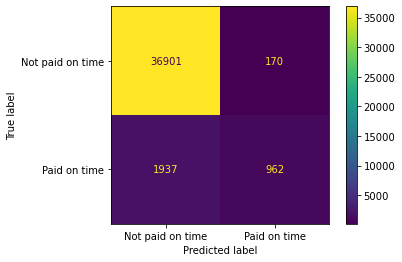

In [54]:
pipe_xgb.fit(X_train, y_train)
plot_confusion_matrix(pipe_xgb, X_test, y_test, display_labels = 
                      ['Not paid on time', 'Paid on time']);

After the optimization, the cross validation roc_auc score increased slightly from **0.831** to **0.835**. It looks like the XGBoost model is not very sensitive to the hyperparameter tuning. On the other hand, the initial model with default parameters performs almost as good as the one after tuning, perhaps due to the inherent regularization.
<br><br>
Looking at the new confusion matrix, of the **37071** people who didn't pay the ticket on time, **36901 (99.54%)** are correctly classified (true negative rate). Of the **2899** people who paid on time, **962 (33.18%)** are correctly classified (true positive rate).
<br><br> 
The false positive rate is **FP / (FP + TN) = 170 / (170 + 36891) = 0.46%**, so the threshold we use now corresponds to the point **(FPR, TPR) = (0.0046, 0.3318)** in the following ROC curve plot. Again, the threshold is changeable in order to move the true positive rate and the false positive rate.
<br><br>
Lastly, we visualize the improvement of hyperparameter tuning by plotting out the ROC curves before and after the optimization. The new curve is just slightly better than the old curve.

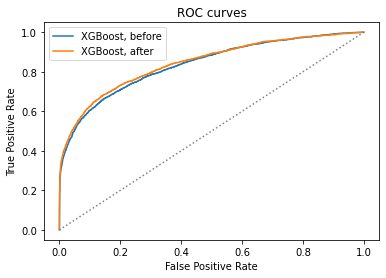

In [57]:
y_test_pred = pipe_xgb.predict_proba(X_test)[:,1]
fpr_xgb_before, tpr_xgb_before, _ = roc_curve(y_test, y_test_pred_before)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred)

fig, ax = plt.subplots()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves')

ax.plot(fpr_xgb_before, tpr_xgb_before, label='XGBoost, before')
ax.plot(fpr_xgb, tpr_xgb, label='XGBoost, after')
ax.legend()
ax.plot([0, 1], [0, 1], ':', c='grey');

Lastly, we compare the Random Forest and the XGBoost models. The Random Forest model performs better at FPR of **0.4 ~ 0.6** but very slightly worse at FPR of **~ 0.1**, compared to the XGBoost model. In general, the Random Forest gives us a better Area Under ROC score.  

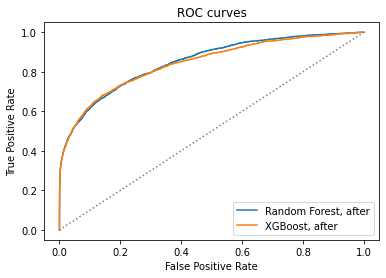

In [56]:
fig, ax = plt.subplots()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves')

ax.plot(fpr_rf, tpr_rf, label='Random Forest, after')
ax.plot(fpr_xgb, tpr_xgb, label='XGBoost, after')
ax.legend()
ax.plot([0, 1], [0, 1], ':', c='grey');

# 5. Final Submission

We will use the Random Forest model to generate predictions on the `test` data for evaluation.

In [51]:
clf_rf = RandomForestClassifier(min_samples_split = 2, max_features = 9,
                                ccp_alpha = 1.2e-5, n_estimators = 750, n_jobs = -1)
pipe_rf = Pipeline(steps = [('transformer', CustomizedTransformer()),
                        ('ohe_scaler', preprocessor),
                        ('todense', FunctionTransformer(lambda x: x.todense(), 
                                                accept_sparse = True)),
                        ('clf', clf_rf)
                        ])
pipe_rf.fit(X, y)

y_eval = pipe_rf.predict_proba(test)[:,1]

y_eval = pd.Series(y_eval).rename(test_id)
y_eval = y_eval.rename('compliance')
y_eval.index.name = 'ticket_id'

y_eval

ticket_id
284932    0.074600
285362    0.030746
285361    0.062704
285338    0.069517
285346    0.071093
            ...   
376496    0.024607
376497    0.024607
376499    0.063282
376500    0.064386
369851    0.507851
Name: compliance, Length: 61001, dtype: float64